In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [5]:
Q = 150  # m/s^3
A = 2000 # m^2
k = 400
kappa = k
R = 10000
L = 10000

pi = np.pi

a = A/pi

In [6]:
def s_tilde(x):
    return (a/R)**(Q/(kappa*pi))*np.exp(-Q*x/(k*A))


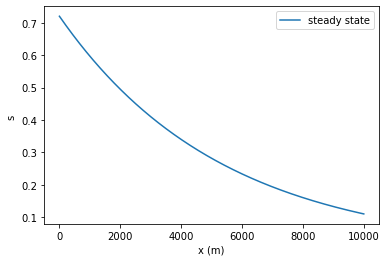

In [7]:
x = np.linspace(0,L,int(1e3))

plt.figure()
plt.plot(x,s_tilde(x), label='steady state')
plt.xlabel('x (m)')
plt.ylabel('s ')
#plt.vlines(B,0,1, color='black')
plt.legend()
plt.show()

In [105]:
N_x = 10

def phi_x_n(x,n):
    return np.exp(-Q*x/(2*k*A))*np.sin(n*pi*x/L)

def labda_x_n(n):
    return (Q/A)**2/(4*k) + k*(n*pi/L)**2


In [106]:
dt = 1e-3
t = np.arange(0,1e-1,dt)


## Final solution
Now that we have the eigenfunctions and $f(t)$ is approximated, we will build the final solution.  
  
First we linearly interpolate the discrete solution for $f(t)$:

In [107]:
# Guess
time_constant = 1
def f_interp(T):
    eq1 = (a/R)**(Q/(kappa*pi))
    eq2 = (a/R)**(0.5*Q/(kappa*pi))
    return eq2 + (eq1-eq2)*np.exp(-time_constant*T)

def f_prime_interp(T):
    eq1 = (a/R)**(Q/(kappa*pi))
    eq2 = (a/R)**(0.5*Q/(kappa*pi))
    return -time_constant*(eq1-eq2)*np.exp(-time_constant*T)

def f_interp(T):
    eq1 = (a/R)**(Q/(kappa*pi))
    eq2 = (a/R)**(0.5*Q/(kappa*pi))
    return eq1 + T/time_constant*eq2

def f_prime_interp(T):
    eq1 = (a/R)**(Q/(kappa*pi))
    eq2 = (a/R)**(0.5*Q/(kappa*pi))
    return eq2/time_constant

Now we calulate $s(x,t)$ and $\zeta(x,t)$:

In [108]:
def xi(x,t):
    return f_interp(t)*(1-x/L)

def ss0(x):
    return s_tilde(x)*(1-x/L)
    #return (a/R)**(0.5*Q/(kappa*pi))*(1-x/L)
    #return (a/R)**(0.5*Q/(kappa*pi))*np.exp(-0.5*Q*x/(k*A))

def u(x):
    return ss0(x) - xi(x,0)

def v(r):
    return ss1(r) - psi(r,0)

# def u(x):
#     return (a/R)**(0.5*Q/(kappa*pi))*np.exp(-2*Q*x/(k*A)) -(1-x/L)*(a/R)**(Q/(kappa*pi))*np.exp(-2*Q*x/(k*A))

# def v(r):
#     f = (a/R)**(0.5*Q/(kappa*pi))
#     return (r/R)**(0.5*Q/(kappa*pi)) - ((f-1)/(a-R)*r + (R*f-a)/(R-a))


In [109]:
def Lf(x,t):
    xi_t = f_prime_interp(t)*(1-x/L)
    xi_xx = 0
    xi_x = -f_interp(t)/L
    return -xi_t + k*xi_xx + Q/A*xi_x


def l(tau,n):
    return integrate.quad(lambda x: Lf(x,tau)*phi_x_n(x,n), 0, L)[0]

def T0_x(n):
    return integrate.quad(lambda x: u(x)*phi_x_n(x,n), 0, L)[0]/integrate.quad(lambda x: phi_x_n(x,n)**2, 0, L)[0]

def T_x(t,n):
    return np.exp(-labda_x_n(n)*t)*T0_x(n) + np.exp(-labda_x_n(n)*t) * integrate.quad(lambda tau: l(tau, n)*np.exp(labda_x_n(n)*tau), 0, t)[0]/integrate.quad(lambda x: phi_x_n(x,n)**2, 0, L)[0]

def sol_x(x,t):
    res = 0
    for i in range(1,N_x):
        res += T_x(t,i)*phi_x_n(x,i)
    return res + xi(x,t)

In [110]:
x = np.linspace(0,L,100)


res = sol_x(x,t[0])

plt.figure(figsize=(12,12))
plt.plot(x, res)
plt.plot(x,ss0(x), '--')
for i in range(0,len(t), 200):
    print(i)
    res = sol_x(x,t[i])
    plt.plot(x, res, label=str(t[i]))
    plt.plot(0, f_interp(t[i]), 'r.')
plt.legend()
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

# The eigenfunctions are not so good... 
See the following example for a simple (EIGEN!!) function $g(x) = e^{-Qx/(2kA)}\sin(\pi x/L)$. Even for 100 terms the eigenfunction series does not really converge.

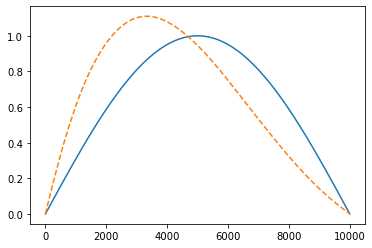

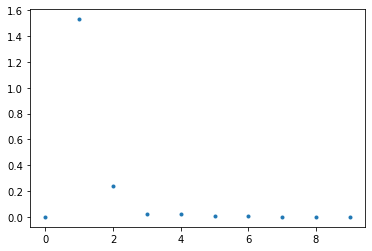

In [37]:
def g(x):
    return np.sin(pi*x/L)
    return np.exp(-Q*x/(2*k*A))*np.sin(4*pi*x/L)

def phi(x,n):
    return np.exp(-Q*x/(2*k*A))*np.sin(n*pi*x/L)

TOL = 1e-20

N_x = 10
a = np.zeros(N_x)
for i in range(1,N_x):
    a[i] = integrate.quadrature(lambda x: g(x)*phi(x,i), 0, L, tol=TOL)[0]/integrate.quadrature(lambda x: phi(x,i)**2, 0, L, tol=TOL)[0]
    
def exp(x):
    res = 0
    for i in range(1,N_x):
        res += a[i]*phi(x,i)
    return res

x = np.linspace(0,L,100)
plt.figure()
plt.plot(x, g(x))
plt.plot(x, exp(x), '--')
plt.show()


plt.figure()
plt.plot(a, '.')
plt.show()

## erg veel spectral leakage... Hoe nu verder...

## Orthogonaliteit van de eigenfuncties:

$$\begin{aligned} 
& \int_{0}^L \phi_n(x) \phi_n(x) dx \\
=& \int_{0}^L e^{-\frac{Q}{kA}x} \sin(\frac{n\pi x}{L}) \sin(\frac{m\pi x}{L}) dx \\
\neq & \delta_{n,m}\\ 
\end{aligned}$$

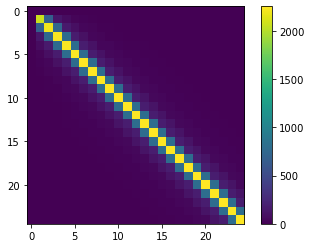

In [38]:
N = 25
J = np.zeros((N,N))

for i in range(1,N):
    for j in range(1,N):
        J[i,j] = integrate.quad(lambda x: phi(x,i)*phi(x,j), 0, L)[0]
        

plt.figure()
plt.imshow(J)
plt.colorbar()
plt.show()

## Toch geen Gram-Schmidt he? Ik vrees het wel.

[ 1.62107221e+00 -2.72810829e-01  2.69175084e-02 -2.36839954e-02
  5.08301736e-03 -6.57772352e-03  1.78633569e-03 -2.71345532e-03
  8.27959408e-04 -1.37492561e-03  4.49898615e-04 -7.91105949e-04
  2.71134623e-04 -4.96341646e-04  1.75682243e-04 -3.31543769e-04
  1.19981804e-04 -2.32135635e-04  8.50588801e-05 -1.68383705e-04
  6.14566164e-05 -1.24836334e-04  4.25820599e-05 -8.85120960e-05]


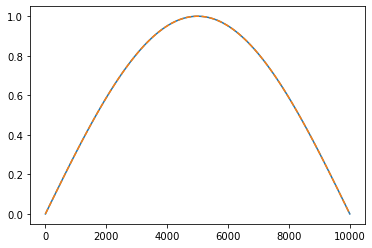

In [39]:
K = J[1:,1:]

inv = np.linalg.inv(K)

q = np.array([integrate.quad(lambda x: g(x)*phi(x,i), 0, L)[0] for i in range(1,N)])


a = inv @ q

print(a)

def res(x):
    return a @ np.array([phi(x,i) for i in range(1,N)])

plt.figure()
plt.plot(x, g(x))
plt.plot(x,res(x), '--')
plt.show()
